# Step 1. Project Description
In this project, we will use the standard machine-learning problem called the iris flowers dataset:

http://archive.ics.uci.edu/ml/datasets/Iris 

This dataset is well studied and is a good problem for practicing on neural networks because all of the 4 input variables are numeric and have the same scale in centimeters. Each instance describes the properties of an observed flower measurements and the output variable is specific iris species.

This is a multi-class classification problem, meaning that there are more than two classes to be predicted, in fact there are three flower species. This is an important type of problem on which to practice with neural networks because the three class values require specialized handling.

The iris flower dataset is a well-studied problem and as such we can expect to achieve model accuracy in the range of 95% to 97%. This provides a good target to aim for when developing our models in this project.

We have download the iris flowers dataset for free and place it in the project directory with the filename “iris.csv“. You can also directly download the dataset:
http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


# Step 2. Making Preparations
We will start off by importing all of the classes and functions we will need. This includes both the functionality we require from Keras, but also data loading from pandas as well as data preparation and model evaluation from scikit-learn:



In [1]:
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


Using TensorFlow backend.


Next, we need to initialize the random number generator to a constant value (7).

This is important to ensure that the results we achieve from this model can be achieved again precisely. It ensures that the stochastic process of training a neural network model can be reproduced:


In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


The dataset can be loaded directly. Because the output variable contains strings, it is easiest to load the data using pandas. We can then split the attributes (columns) into input variables (x) and output variables (y).

In [3]:
# load dataset
dataframe = pd.read_csv("iris.csv", header=None)
dataframe.describe()


,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [53]:
# normalized  = dataframe.copy()
# normalized_data = normalized.iloc[:,0:4]
# normalized_target = normalized.iloc[:,4:]
# normalized_data = normalized_data/normalized_data.max(axis=0)
# normalized = pd.concat([normalized_data, normalized_target], axis = 1)
# dataset = normalized.values


In [50]:
dataset = dataframe.values
x = dataset[:,0:4].astype(float)
y = dataset[:,4]

The output variable contains three different string values.
<p>
When modeling multi-class classification problems using neural networks, it is good practice to reshape the output attribute from a vector that contains values for each class value to be a matrix with a boolean for each class value and whether or not a given instance has that class value or not.
<p/>
<p>
This is called one hot encoding or creating dummy variables from a categorical variable:
https://en.wikipedia.org/wiki/One-hot
<p/>
<p>
For example, in this problem three class values are Iris-setosa, Iris-versicolor and Iris-virginica. If we had the observations:
<p/>
<p>
Iris-setosa
</p>
Iris-versicolor

Iris-virginica

We can turn this into a one-hot encoded binary matrix for each data instance that would look as follows:

Iris-setosa,	Iris-versicolor,	              Iris-virginica
1,		0,			0
0,		1, 			0
0, 		0, 			1


We can do this by first encoding the strings consistently to integers using the scikit-learn class LabelEncoder. Then convert the vector of integers to a one hot encoding using the Keras function to_categorical().


In [51]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(y_encoded)


Step 3: Define the Neural Network Baseline Model
The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in scikit-learn.

There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.

Below is a function that will create a baseline neural network for the iris classification problem. It creates a simple fully connected network with one hidden layer that contains 8 neurons.

The hidden layer uses a rectifier activation function, which is a good practice. Because we used a one-hot encoding for our iris dataset, the output layer must create 3 output values, one for each class. The output value with the largest value will be taken as the class predicted by the model.

The network topology of this simple one-layer neural network can be summarized as:


4 inputs -> [8 hidden nodes] -> 3 outputs

Note that we use a “softmax” activation function in the output layer. This is to ensure the output values are in the range of 0 and 1 and may be used as predicted probabilities.

Finally, the network uses the efficient Adam gradient descent optimization algorithm with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.


In [6]:
# define baseline model
def baseline_model():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

We can now create our KerasClassifier for use in scikit-learn.

We can also pass arguments in the construction of the KerasClassifier class that will be passed on to the fit() function internally used to train the neural network. Here, we pass the number of epochs as 200 and batch size as 5 to use when training the model. Debugging is also turned off when training by setting verbose to 0.


In [7]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

# Step 4. Evaluate The Model with k-Fold Cross Validation
We can now evaluate the neural network model on our training data.

The scikit-learn has excellent capability to evaluate models using a suite of techniques. The gold standard for evaluating machine learning models is k-fold cross validation.

First we can define the model evaluation procedure. Here, we set the number of folds to be 10 (an excellent default) and to shuffle the data before partitioning it.


In [8]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

Now we can evaluate our model (estimator) on our dataset (X and dummy_y) using a 10-fold cross-validation procedure (kfold).

Evaluating the model only takes approximately 10 seconds and returns an object that describes the evaluation of the 10 constructed models for each of the splits of the dataset.


In [9]:
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 97.33% (4.42%)


The results are summarized as both the mean and standard deviation of the model accuracy on the dataset. This is a reasonable estimation of the performance of the model on unseen data. It is also within the realm of known top results for this problem.

# Step 5. Tuning Layers and Number of Neurons in The Model
There are many things to tune on a neural network, such as the weight initialization, activation functions, optimization procedure and so on.

One aspect that may have an outsized effect is the structure of the network itself called the network topology. In this section, we take a look at two experiments on the structure of the network: making it smaller and making it larger.

These are good experiments to perform when tuning a neural network on your problem.


## Step 5.1. Evaluate a Smaller Network


In [56]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define small model
def small_model():
  model = models.Sequential()
  model.add(layers.Dense(4, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=small_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 82.67% (24.07%)


## Step 5.2. Evaluate a Larger Network
A neural network topology with more layers offers more opportunity for the network to extract key features and recombine them in useful nonlinear ways.

We can evaluate whether adding more layers to the network improves the performance easily by making another small tweak to the function used to create our model. 

The idea here is that the network is given the opportunity to model all input variables before being bottlenecked and forced to halve the representational capacity, much like we did in the experiment above with the smaller network.

Instead of squeezing the representation of the inputs themselves, we add hidden layers to aid in the process.


In [57]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define large model
def large_model():
  model = models.Sequential()
  model.add(layers.Dense(16, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(6, activation = 'relu'))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=large_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 97.33% (4.42%)


# Step 6. Really Scaling up: developing a model that overfits
Once you’ve obtained a model that has statistical power, the question becomes, is your
model sufficiently powerful? Does it have enough layers and parameters to properly
model the problem at hand? 

Remember that the universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

To figure out how big a model you’ll need, you must develop a model that overfits.
This is fairly easy:
1.	Add layers.
2.	Make the layers bigger.
3.	Train for more epochs.

Always monitor the training loss and validation loss, as well as the training and validation values for any metrics you care about. When you see that the model’s performance on the validation data begins to degrade, you’ve achieved overfitting.

The next step is to start regularizing and tuning the model, to get as close as possible to the ideal model that neither underfits nor overfits.


In [58]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define large model
def large_model():
  model = models.Sequential()
  model.add(layers.Dense(30, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(20, activation = 'relu',))
  model.add(layers.Dense(10, activation = 'relu',))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=large_model, epochs=250, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.67% (4.47%)


# Step 7. Tuning the Model
With further tuning of aspects like the optimization algorithm etc. and the number of training epochs, it is expected that further improvements are possible. What is the best score that you can achieve on this dataset?


In [59]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# running the same small model with 100 epocs
def model_v1():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v1, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 95.33% (5.21%)


In [60]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# running the small model with 200 epocs
def model_v2():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v2, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 97.33% (4.42%)


In [61]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# running the small model with rmsprop
def model_v3():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v3, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.00% (5.33%)


In [62]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# again model with adam but with 6 neurons in hidden layer
def model_v4():
  model = models.Sequential()
  model.add(layers.Dense(6, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v4, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 93.33% (9.89%)


In [63]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# again model with adam but with 4 neurons in hidden layer
def model_v5():
  model = models.Sequential()
  model.add(layers.Dense(4, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v5, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 82.67% (24.07%)


In [64]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# introducing dropout of 20%
def model_v6():
  model = models.Sequential()
  model.add(layers.Dense(4, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v6, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 91.33% (13.68%)


In [65]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# Using regularizers l1
from keras import regularizers

def model_v7():
  model = models.Sequential()
  model.add(layers.Dense(4, activation = 'relu',kernel_regularizer = regularizers.l1(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v7, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 92.67% (10.09%)


In [66]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# Using regularizers l2
from keras import regularizers

def model_v8():
  model = models.Sequential()
  model.add(layers.Dense(4, activation = 'relu',kernel_regularizer = regularizers.l2(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimator = KerasClassifier(build_fn=model_v8, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 84.67% (21.51%)


In [67]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# Using L1 Regularizer and standarizing the dataset
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def model_v7():
  model = models.Sequential()
  model.add(layers.Dense(4, activation = 'relu',kernel_regularizer = regularizers.l1(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v7, epochs=200, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 95.33% (4.27%)


In [68]:
# Using model_v2 again with standarized data set
seed = 7
np.random.seed(seed)

def model_v8():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v8, epochs=200, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 94.00% (5.54%)


In [70]:
# Using model_v2 again with standarized data set and L1 regularizer
seed = 7
np.random.seed(seed)

def model_v9():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu',kernel_regularizer = regularizers.l1(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v9, epochs=200, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



Larger: 94.00% (5.54%)


In [71]:
# Using model_v2 again with L1 regularizer
seed = 7
np.random.seed(seed)

def model_v10():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu',kernel_regularizer = regularizers.l1(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model


estimator = KerasClassifier(build_fn=model_v10, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Baseline: 96.67% (4.47%)


In [73]:
# Using model_v2 again with L2 regularizer
seed = 7
np.random.seed(seed)

def model_v11():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu',kernel_regularizer = regularizers.l2(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model


estimator = KerasClassifier(build_fn=model_v11, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 97.33% (4.42%)


In [74]:
# Using rmsprop optimizer
seed = 7
np.random.seed(seed)

def model_v12():
  model = models.Sequential()
  model.add(layers.Dense(8, activation = 'relu',kernel_regularizer = regularizers.l2(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model


estimator = KerasClassifier(build_fn=model_v12, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.00% (5.33%)


In [75]:
# Using adam optimizer and different architecture
seed = 7
np.random.seed(seed)

def model_v13():
  model = models.Sequential()
  model.add(layers.Dense(10, activation = 'relu',kernel_regularizer = regularizers.l2(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model


estimator = KerasClassifier(build_fn=model_v13, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 98.00% (3.06%)


In [11]:
# Using different architecture
from keras import regularizers
seed = 7
np.random.seed(seed)

def model_v14():
  model = models.Sequential()
  model.add(layers.Dense(12, activation = 'relu',kernel_regularizer = regularizers.l2(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model


estimator = KerasClassifier(build_fn=model_v14, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 97.33% (4.42%)


In [14]:
#Using model_v13 with dropout
seed = 7
np.random.seed(seed)

def model_v15():
  model = models.Sequential()
  model.add(layers.Dense(10, activation = 'relu', input_shape = x[1].shape))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model


estimator = KerasClassifier(build_fn=model_v15, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.67% (5.37%)


So model v_13 is the best one we got so far so we will go with that

# Step 8. Rewriting the code using the Keras Functional API
Review the April 9, 2018 presentation done by Chollet contained in the project file: 

Francois_Chollet_March9.pdf

Now rewrite the code that you have written so far using the Keras Sequential API in Kearas Functional API.


In [20]:
import keras
seed = 7
np.random.seed(seed)


def create_model():
  
  inputs = keras.Input(shape=x[1].shape)
  x_1 = layers.Dense(10,activation = 'relu',kernel_regularizer = regularizers.l2(0.001))(inputs)
  outputs = layers.Dense(3, activation = 'softmax')(x_1)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['acc'] )
  return model

estimator = KerasClassifier(build_fn=create_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 98.00% (3.06%)


# Step 9. Rewriting the code by doing Model Subclassing
Now rewrite the code that you have written so far using the Keras Model Subclassing as mentioned in the Chollet April 9, 2018 presentation.

Reference:
https://www.tensorflow.org/api_docs/python/tf/keras/Model
Please note you will have to use TensorFlow 1.7+ with built-in Keras. 


In [52]:
import keras
seed = 7
np.random.seed(seed)

class MyModel(keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = layers.Dense(10, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))
    self.dense2 = layers.Dense(3, activation = 'softmax')
   
    
  def call(self, inputs):
    x_1 = self.dense1(inputs)
    return self.dense2(x_1)
  
def create_model():
  model = MyModel()
  model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'] )
  return model

estimator = KerasClassifier(build_fn=create_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 98.00% (3.06%)


# Step 10. Rewriting the code without using scikit-learn
Once you have written the model in all three API style you are required to do k-fold cross validation without using scikit-learn library.


In [35]:
dataset = dataframe.values
np.random.shuffle(dataset)
x = dataset[:,0:4].astype(float)
y = dataset[:,4]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(y_encoded)

x1 = x.copy()
y1 = dummy_y.copy()
x_test = x1[140:]
y_test = y1[140:]
x_data = x1[:140]
y_data = y1[:140]
# x_data = x_data-x_data.mean(axis=0)
# x_data = x_data/x_data.std(axis=0)
# x_test = x_test-x_data.mean(axis=0)
# x_test = x_test/x_data.std(axis=0)

In [36]:
seed = 7
np.random.seed(seed)

def model_v13():
  model = models.Sequential()
  model.add(layers.Dense(10, activation = 'relu',kernel_regularizer = regularizers.l2(0.001), input_shape = x[1].shape))
  model.add(layers.Dense(3, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
  return model

k = 10
num_val_samples = len(x_data) // k #integer division
print(num_val_samples)
num_epochs = 200
loss_values = []
val_loss_values = []

for i in range(k):
    print("Processing field #", i)
    #prepairing the validation data:data from partition K
    val_data = x_data[i*num_val_samples:(i+1)*num_val_samples]      
    val_targets = y_data[i*num_val_samples:(i+1)*num_val_samples]
    #prepairing training data from all other partitions
    partial_train_data = np.concatenate([
        x_data[:i*num_val_samples],
        x_data[(i+1)*num_val_samples:]
    ], axis = 0)
    partial_train_target = np.concatenate([
        y_data[:i*num_val_samples],
        y_data[(i+1)*num_val_samples:]
    ],axis = 0)
    
   
    model = model_v13()
    history = model.fit(partial_train_data, 
              partial_train_target,
              epochs = num_epochs, 
              batch_size = 5, verbose = 0,
              validation_data = (val_data, val_targets))
    history_dict = history.history
    loss_values.append(history_dict['loss'])
    val_loss_values.append(history_dict['val_loss'])

14
Processing field # 0
Processing field # 1
Processing field # 2
Processing field # 3
Processing field # 4
Processing field # 5
Processing field # 6
Processing field # 7
Processing field # 8
Processing field # 9


In [37]:
average_loss_history = [np.mean([x[i] for x in loss_values]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in val_loss_values]) for i in range(num_epochs)]

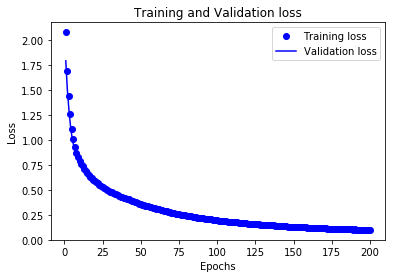

In [39]:
import matplotlib.pyplot as plt
epochs = range(1, len(average_loss_history)+1)
plt.plot(epochs, average_loss_history, 'bo', label = 'Training loss')
plt.plot(epochs, average_val_loss_history, 'b', label = 'Validation loss')
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [40]:
model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 0us/step


[0.12449132651090622, 1.0]